#### TMA4205 Numerical Linear Algebra
# Project Part 2
## Introduction

In this part we want to find a low rank continuous approximation to a continuous matrix valued function.

In [29]:
import numpy as np
%load_ext autoreload
%autoreload 2

# imports and useful functions
import matplotlib.pyplot as plt

# line cyclers adapted to colourblind people
from cycler import cycler

line_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
               cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
plt.rc("axes", prop_cycle=line_cycler)
plt.rc('axes', axisbelow=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
"""First define some useful functions for plotting and testing"""
from linalg.plotting import *
from linalg.helpers import get_function_timings

## Exercise 1:
We implement Lanczos bidiagonalization method with and without re-orthogonalization.

In [31]:
from linalg.bidiagonalization import lanczos_bidiag, lanczos_bidiag_reorth

Make 3 randomly generated matrices $A_n \in \mathbb{R}^{n\times n} $, $n \in [32,64,128]$.
Then we show their eigenvalues.

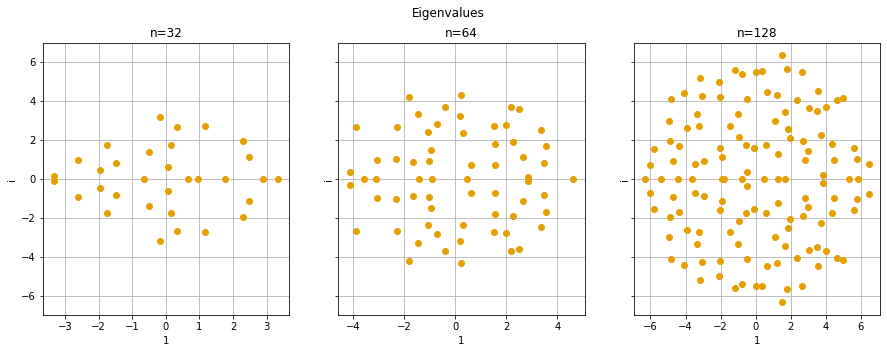

In [32]:
# make matrices
n_list = [32, 64, 128]
A_list = [np.random.rand(n, n) * 2 - 1 for n in n_list]

# plot their eigenvalues
fig, axs = plt.subplots(ncols=len(n_list), sharey=True, figsize=(15, 5))
fig.suptitle("Eigenvalues")
for A, ax, n in zip(A_list, axs, n_list):
    eigenvals, _ = np.linalg.eig(A)
    ax.scatter(eigenvals.real, eigenvals.imag)
    ax.grid()
    ax.set_xlabel("1")
    ax.set_ylabel("i")
    ax.set_title(f"n={n}")

Now we approximate the matrix $A_n$ with different approximation methods.
The truncated SVD gives the best approximation matrix of rank $k \leq$ (in Frobenius norm).
For all $k \leq n$ compare the best approximation with Lanczos bidiagonalization method, with and without re-orthogonalization.

We also measure the orthogonality error with the method from [5]:

$
\begin{equation}
    \eta(U) :=  ||I -U^T U||_F
\end{equation}
$

For each $k$ we also show this error for bidiagonalization with and without reorthogonalization.

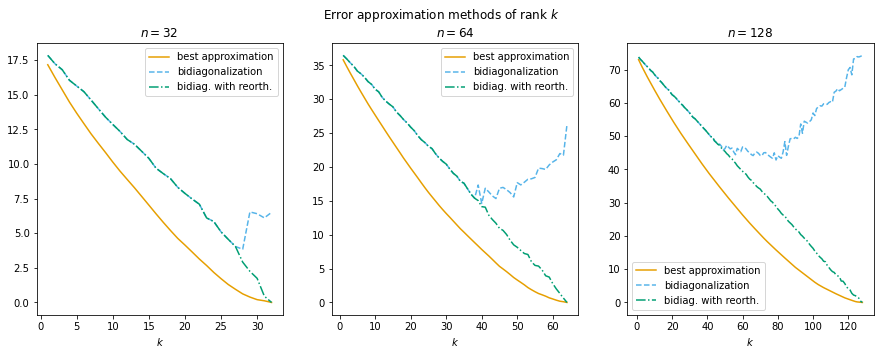

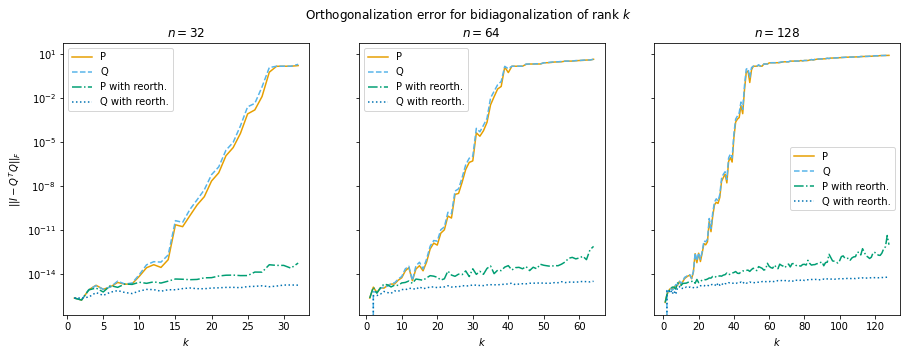

In [33]:
from linalg.helpers import get_best_approx, make_bidiagonal

fig, axs = plt.subplots(ncols=len(n_list), figsize=(15, 5))
fig.suptitle("Error approximation methods of rank $k$ ")

orth_fig, orth_axs = plt.subplots(ncols=len(n_list), sharey=True, figsize=(15, 5))
orth_fig.suptitle("Orthogonalization error for bidiagonalization of rank $k$")
orth_axs[0].set_ylabel("$||I - Q^{T}Q||_F$")
for A, n, ax, orth_ax in zip(A_list, n_list, axs, orth_axs):
    best_approx_error = np.zeros(n)
    bidiagonal_error = np.zeros(n)
    bidiagonal_reorth_error = np.zeros(n)

    # error: [P, Q, P_reorth, Q_reorth]
    reorth_error = np.zeros((n, 4))

    k_list = np.arange(1, n + 1)
    for i, k in enumerate(range(1, n + 1)):
        b = np.random.rand(n)
        P, Q, alpha, beta = lanczos_bidiag(A, k, b)
        B = make_bidiagonal(alpha, beta)
        bidiagonal_error[i] = np.linalg.norm(A - P @ B @ Q.T, ord="fro")
        reorth_error[i, 0] = np.linalg.norm(np.eye(k) - P.T @ P, ord="fro")
        reorth_error[i, 1] = np.linalg.norm(np.eye(k) - Q.T @ Q, ord="fro")

        P, Q, alpha, beta = lanczos_bidiag_reorth(A, k, b)
        B = make_bidiagonal(alpha, beta)
        bidiagonal_reorth_error[i] = np.linalg.norm(A - P @ B @ Q.T, ord="fro")
        reorth_error[i, 2] = np.linalg.norm(np.eye(k) - P.T @ P, ord="fro")
        reorth_error[i, 3] = np.linalg.norm(np.eye(k) - Q.T @ Q, ord="fro")

        A_k = get_best_approx(A, k)
        best_approx_error[i] = np.linalg.norm(A - A_k, ord="fro")

    ax.plot(k_list, best_approx_error, label="best approximation")
    ax.plot(k_list, bidiagonal_error, label="bidiagonalization")
    ax.plot(k_list, bidiagonal_reorth_error, label="bidiag. with reorth.")
    ax.set_xlabel("$k$")
    ax.set_title(f"$n={n}$")
    ax.legend()

    #plot orthogonality error
    orth_ax.semilogy(k_list, reorth_error[:, 0], label="P")
    orth_ax.semilogy(k_list, reorth_error[:, 1], label="Q")
    orth_ax.semilogy(k_list, reorth_error[:, 2], label="P with reorth.")
    orth_ax.semilogy(k_list, reorth_error[:, 3], label="Q with reorth.")
    orth_ax.set_xlabel("$k$")
    orth_ax.set_title(f"$n={n}$")
    orth_ax.legend()


From figures above we see that bidiagonalization without re-orthogonalization does not give good approximations for large $k$.
The reason for this is that numerical instability makes the columns of $Q$ and $P$ not orthonormal.

## Exercise 2
In the following code block the integration method of order 2 is implemented.
A method of order 1 is also used to obtain an estimate for the local truncation error.
The step size is then determined based on this local truncation error.

In [34]:
from linalg.integrate import *

To make sure that the resulting matrices are in fact orthogonal we take steps in using the caylay-map.
Furthermore all inputs in they caylay map are given on the form $B = [F, -U] [U, F]^T$.
Where $U^TU = I$ and $F^T U=0$
This input form we can exploit to compute the caylay map more efficiently:
...

In [35]:
from linalg.cayley_map import cayley_map_simple, cayley_map_plus, cayley_map_efficient

We now compare the performance of the different ways to compute the caylay map.
The cases are constructed by first generating matrices $A$ and $B$.
$A$ and $B$ are random matrices with elements randomly drawn from the uniform distribution on [0,1].
Then we compute the QR factorization of $A$ and set $Q$ as the $U$ matrix.
Then $F$ is computed as $F:=(I - U U^T)G $

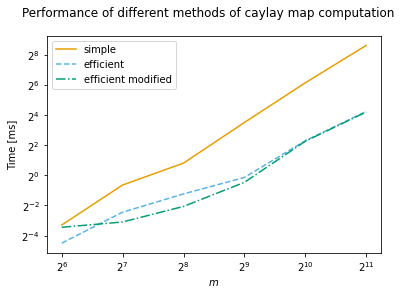

In [54]:
from test.test_caylay import get_FUCDB

m_list = [64, 128, 256, 512,1024, 2048]

sample_FUCDB = [get_FUCDB(m, k=int(np.sqrt(m))) for m in m_list]
sample_FU = [(F, U) for F, U, C, D, B in sample_FUCDB]
sample_CD = [(C, D) for F, U, C, D, B in sample_FUCDB]
sample_B = [(B,) for F, U, C, D, B in sample_FUCDB]

time_simple = get_function_timings(cayley_map_simple, sample_B, number=10)
time_efficient = get_function_timings(cayley_map_efficient, sample_CD, number=10)
time_plus = get_function_timings(cayley_map_plus, sample_FU, number=10)

fig, ax = plt.subplots()
fig.suptitle("Performance of different methods of caylay map computation")
ax.loglog(m_list,time_simple, label="simple", base=2)
ax.loglog(m_list,time_efficient, label="efficient", base=2)
ax.loglog(m_list,time_plus, label="efficient modified", base=2)

ax.set_ylabel("Time [ms]")
ax.set_xlabel("$m$")
ax.legend()

insert

insert


insert

